## Download the training data from the S3 bucket to the local machine.




In [4]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

In [7]:
import pandas as pd

file = "file path"
with s3.open(file, mode="rb") as f:
    df = pd.read_parquet(f)

## Preprocess the data by tokenizing the text and removing stop words and special characters.


### The notebook cell below writes a file preprocessing.py, which contains the pre-processing script <br>
-  Removes stopwords
-  Removes special characters
-  Transforms text to tfidf features

In [ ]:
%%writefile preprocessing.py

from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer

STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

SPECIAL_CHARACTERS_TO_REMOVE = string.punctuation

def remove_special_characters(text):
    
    return text.translate(str.maketrans('', '', SPECIAL_CHARACTERS_TO_REMOVE))


if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-test-split-ratio", type = float, default=0.3)
    args, _ = parser.parse_known_args()
    
    print("Received arguments {}".format(args))
    
    input_data_path = os.path.join("file_path", "file.parquet")
    
    with s3.open(file, mode="rb") as f:
        df = pd.read_parquet(input_data_path)
        
    
    df['text_lower'] = df['text'].str.lower()
    df['text_wo_stopwords'] = df['text_lower'].apply(lambda text: remove_stopwords(text))
    
    df['text_wo_spec_chars'] = df['text_wo_stopwords'].apply(lambda text: remove_special_characters(text))
    
    split_ratio = args.train_test_split_ratio
    print("Splitting data into train and test sets")
    X_train, X_test, y_train, y_test = train_test_split(df['text_wo_spec_chars'], df['target'], test_size = split_ratio,
                                                        random_state = 0
                                                       )
    
    tf_idf = TfidfVectorizer()
    train_features = tf_idf.fit_transform(X_train)
    test_features = tf_idf.transform(X_test)
    
    
    train_features_output_path = os.path.join("/opt/ml/processing/train", "train_features.csv")
    train_labels_output_path = os.path.join("/opt/ml/processing/train", "train_labels.csv")

    test_features_output_path = os.path.join("/opt/ml/processing/test", "test_features.csv")
    test_labels_output_path = os.path.join("/opt/ml/processing/test", "test_labels.csv")

    print("Saving training features to {}".format(train_features_output_path))
    pd.DataFrame(train_features).to_csv(train_features_output_path, header=False, index=False)

    print("Saving test features to {}".format(test_features_output_path))
    pd.DataFrame(test_features).to_csv(test_features_output_path, header=False, index=False)

    print("Saving training labels to {}".format(train_labels_output_path))
    y_train.to_csv(train_labels_output_path, header=False, index=False)

    print("Saving test labels to {}".format(test_labels_output_path))
    y_test.to_csv(test_labels_output_path, header=False, index=False)
    
    
    
    


### Run the above script on Sagemaker as a processing job

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(
    code="preprocessing.py",
    inputs=[ProcessingInput(source=input_data, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]

## Training using the features from preprocessing job

### The train.py script below is used to run a training job <br>

- Trains a NB classifier
- Saves the model to /opt/ml/model directory which Sagemaker tars and uploads into a model.tar.gz file into S3 at the end of training job

In [ ]:
%%writefile train.py

import os

import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib

if __name__ == "__main__":
    training_data_directory = "/opt/ml/input/data/train"
    train_features_data = os.path.join(training_data_directory, "train_features.csv")
    train_labels_data = os.path.join(training_data_directory, "train_labels.csv")
    print("Reading input data")
    X_train = pd.read_csv(train_features_data, header=None)
    y_train = pd.read_csv(train_labels_data, header=None)

    model = naive_bayes_classifier = MultinomialNB()
    print("Training NB model")
    model.fit(X_train, y_train)
    model_output_directory = os.path.join("/opt/ml/model", "model.joblib")
    print("Saving model to {}".format(model_output_directory))
    joblib.dump(model, model_output_directory)

### Run the training job

In [ ]:
from sagemaker.sklearn.estimator import SKLearn

sklearn = SKLearn(
    entry_point="train.py", framework_version="0.20.0", instance_type="ml.m5.xlarge", role=role
)

sklearn.fit({"train": preprocessed_training_data})
training_job_description = sklearn.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

## Model evaluation


### evaluation.py is the model evaluation script <br>

- Takes trained model and test dataset as input
- Produces json containing classification evaluation metrics

In [ ]:
%%writefile evaluation.py

import json
import os
import tarfile

import pandas as pd

from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

if __name__ == "__main__":
    model_path = os.path.join("/opt/ml/processing/model", "model.tar.gz")
    print("Extracting model from path: {}".format(model_path))
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    print("Loading model")
    model = joblib.load("model.joblib")

    print("Loading test input data")
    test_features_data = os.path.join("/opt/ml/processing/test", "test_features.csv")
    test_labels_data = os.path.join("/opt/ml/processing/test", "test_labels.csv")

    X_test = pd.read_csv(test_features_data, header=None)
    y_test = pd.read_csv(test_labels_data, header=None)
    predictions = model.predict(X_test)

    print("Creating classification evaluation report")
    report_dict = classification_report(y_test, predictions, output_dict=True)
    report_dict["accuracy"] = accuracy_score(y_test, predictions)
    report_dict["roc_auc"] = roc_auc_score(y_test, predictions)

    print("Classification report:\n{}".format(report_dict))

    evaluation_output_path = os.path.join("/opt/ml/processing/evaluation", "evaluation.json")
    print("Saving classification report to {}".format(evaluation_output_path))

    with open(evaluation_output_path, "w") as f:
        f.write(json.dumps(report_dict))

In [ ]:
import json
from sagemaker.s3 import S3Downloader

sklearn_processor.run(
    code="evaluation.py",
    inputs=[
        ProcessingInput(source=model_data_s3_uri, destination="/opt/ml/processing/model"),
        ProcessingInput(source=preprocessed_test_data, destination="/opt/ml/processing/test"),
    ],
    outputs=[ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation")],
)
evaluation_job_description = sklearn_processor.jobs[-1].describe()

### Retrieve evaluation metrics

In [ ]:
evaluation_output_config = evaluation_job_description["ProcessingOutputConfig"]
for output in evaluation_output_config["Outputs"]:
    if output["OutputName"] == "evaluation":
        evaluation_s3_uri = output["S3Output"]["S3Uri"] + "/evaluation.json"
        break

evaluation_output = S3Downloader.read_file(evaluation_s3_uri)
evaluation_output_dict = json.loads(evaluation_output)
print(json.dumps(evaluation_output_dict, sort_keys=True, indent=4))

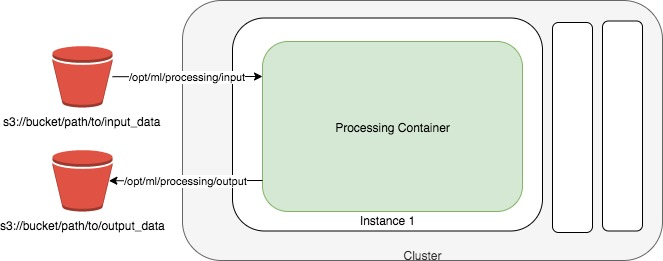

## Adding custom dependencies to the processing container 

In [ ]:
from sagemaker.processing import FrameworkProcessor

est_cls = sagemaker.sklearn.estimator.SKLearn
framework_version_str = "0.20.0"

script_processor = FrameworkProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    estimator_cls=est_cls,
    framework_version=framework_version_str,
)